### CE310 Spring 2020/21: Genetic Algorithms
## Assignment: Programming Assignment and mini project Part 1 (of 2) – Mini project
## Michael Allport, ma18533, 1802882


## Main Genetic Algorithm class

In [1]:
import random, math
import numpy as np
import time
from itertools import combinations
from typing import Callable
from operator import itemgetter
import pdb

class GASettings():
    def __init__(self, 
                 N: int,
                 generations: int = 60,
                 populationSize: int = 100,
                 xoRate: float = 0.8,
                 mutationRate: float = 0.01,
                 tournamentSize: int = 3,
                 single_point_xo = True):
        """GASettings purpose is to store the hyperparameters available for the GA, 
        and instantiate default parameters if the user does not specify"""
        self.N = N
        self.generations = generations
        self.populationSize = populationSize
        self.xoRate = xoRate
        self.mutation_rate = mutationRate
        self.tournamentSize = tournamentSize
        self.single_point_xo = single_point_xo

class GASteadyStateBinary:
    
    """Main Genetic Algorithm class

    This uses a one point crossover operator with Tournament selection and maintains
    the fittest individual over all generations.
    
    Algorithm takes GASettings as input to initialize hyper parameters, and a Fitness
    function for an instance of the GA, alongside a boolean indicating whether to
    print the population at each generation (defaults to false, mainly for debugging)
    
    the data structure for an individual in population is (chromosome, fitness) where
    chromosome is the bitstring representation of the genotype

    The class has been designed such that one may override the MainLoop if required"""
    def __init__(self,
                 Fitness: Callable, 
                 settings: GASettings,
                 printGenerations: bool = False):
        self.Fitness = Fitness
        self.N = settings.N
        self.generations = settings.generations
        self.populationSize = settings.populationSize
        self.xoRate = settings.xoRate
        self.mutation_rate = settings.mutation_rate
        self.tournamentSize = settings.tournamentSize
        self.population = []
        self.InitPopulation()
        self.printGenerations = printGenerations
        self.single_point_xo = settings.single_point_xo
    
    def InitPopulation(self):
        """InitPopulation populates the instances '_population' list with 
        '_populationSize' individuals containing randomized chromosomes, initializes
        the population"""
        for i in range(self.populationSize):
            chromosome = [np.random.randint(0, 2) for i in range(self.N)]
            chromoFit = (chromosome, self.Fitness(chromosome))
            if (i == 0):
                self.fittest = chromoFit
            else:
                if (chromoFit[1] > self.fittest[1]):
                    self.fittest = chromoFit
            self.population.append(chromoFit)

    def CrossOver(self):
        """CrossOver creates offspring with a mixture of the parents chromosomes
        with the option to use single point or uniform (default settings is 1point)"""
        firstParent = self.population[self.Tournament()][0]
        secondParent = self.population[self.Tournament()][0]
        
        if self.single_point_xo:
            ##one point xo
            crossOverPoint = np.random.randint(1, self.N-1)
            childChromo = firstParent[0:crossOverPoint] + secondParent[crossOverPoint:]

        else:
            ## Uniform crossover
            uniformCrossover = (np.random.randint(0,2,self.N))
            childChromo = [firstParent[i] if uniformCrossover[i] == 0 else secondParent[i] for i in range(self.N)]
        
        child = (childChromo, self.Fitness(childChromo))
        index = self.Tournament(False)
        self.population[index] = child
        return index
        

    def Tournament(self, highest: bool = True):
        """Tournament function selects 'tournamentSize' number of individuals from
        the population at random and returns the index of either the fittest rated
        individual or the least fittest individual from the selection dependance on
        'highest' argument"""
        index = np.random.randint(0, self.populationSize-1, self.tournamentSize)
        individuals = [(i, self.population[i][1]) for i in index]
        if highest:
            individual = max(individuals, key = itemgetter(1))
        else:
            individual = min(individuals, key = itemgetter(1))
        return individual[0]

    def Mutate(self, index: int):
        """Mutate flips bits in an individuals chromosome randomly by generating an
        array of values between 0-1 and converting them to a boolean based on the
        mutation rate. If the random bool is true at position x then it flips the
        individuals chromosome at position x"""
        chromosome = self.population[index][0]
        for i in range(len(chromosome)):
            if np.random.rand() <= self.mutation_rate:
                if chromosome[i] == 0:
                    chromosome[i] = 1 
                else:
                    chromosome[i] = 0
        chromoFit = (chromosome, self.Fitness(chromosome))
        if (chromoFit[1] > self.fittest[1]):
            self.fittest = chromoFit
        # I have no idea how this following situation occurs, but it does
        if (self.fittest[1] != self.Fitness(self.fittest[0])):
            self.fittest = (self.fittest[0], self.Fitness(self.fittest[0]))
        self.population[index] = chromoFit
        

    def GetBest(self):
        return self.fittest

    
    def MainLoop(self):
        """The main loop for generating new generations, this has been made a seperate
        function such that an outside party may override this function and it still be 
        runnable via self.Run"""
        for gen in range(self.generations):
            for individual in range(len(self.population)):
                if np.random.random() <= self.xoRate:
                    # XO, return index of individual
                    index = self.CrossOver()
                else:
                    # cloning
                    index = self.Tournament()
                self.Mutate(index)
            if (self.printGenerations):
                print(f'Generation: {gen}')
                self.PrintGeneration(self)
    
    def PrintGeneration(self, GA):
        for i in range(len(self.population)):
            print(self.population[i])
        
    def Run(self):
        self.MainLoop()

def SetRandom(value = time.time()):
    """Simple function to reset the seed of numpy's random either using given argument
    or now time which would be sufficiently random"""
    np.random.seed(value)
    
def PrintCombinations(value):
    """prints total number of combinations"""
    input = list(range(value))
    sum = 0
    for i in range(len(input)):
        sum += math.factorial(value) / (math.factorial(i) * math.factorial((len(input) - i)))
    print(f'Number of combinations: {str(sum)}')

## Maximise the Ones

In [12]:
#routines for 1's problem, calculating fitness, printing, and running

def Fitness(chromosome: list):
    """Fitness function that sums the total amount of 1's found in a chromosome"""
    global count
    count = count + 1
    return sum(chromosome)

def Print1s(GA, printTime = False):
    winner = GA.GetBest()
    winnerChrom = winner[0]
    '''Prints the winner and settings'''
    print("Winning BitString: " + str([winnerChrom[i] for i in range(len(winnerChrom))]))
    print(("\nSettings\n%-24s: %d\n%-24s: %d\n%-24s: %1.1f" +
           "\n%-24s: %3.2f\n%-24s: %d") % (
        "Generations", generations, 
        "Population Size", populationSize, 
        "Xo Rate", xoRate, 
        "Mutation Rate", mutationRate, 
        "Tournament Size", tournamentSize))
    print("\n%-24s: %d" % ("Total 1s", Fitness(winnerChrom)))
    if (printTime):
        print("%-24s: %1.2f" % ("Total time in seconds", time_end - time_start))
        print("%-24s: %d" % ("Total evalutations", count))
    
    
def Run1s(settings):
    '''quick function to initialize and run a GA for 1's problem'''
    GA = GASteadyStateBinary(Fitness, settings)
    time_start = time.time()
    GA.Run()
    return GA
    
# calculates mean over n runs
def CalcMean1s(settings, n: int):
    '''Runs n times and calculates mean fitness'''
    totalFitness = 0
    for i in range(n):
        GA = Run1s(settings)
        winner = GA.GetBest()
        winnerChrom = winner[0]
        totalFitness += Fitness(winnerChrom)
    avgFitness = totalFitness / n
    print("\nTimes tested: %d\nMean 1's: %-10.2f" % (n, avgFitness))
    

## Hyper parameter testing during 1's problem

In [13]:
# start of hyper parameter testing
# xoRate 0.6
# inits settings
numBits = 100
generations: int = 30
populationSize: int = 100
xoRate: float = 0.6
mutationRate: float = 0.01 # 1 / nbits
tournamentSize: int = 3
count = 0

#runs once
time_start = time.time()
settings = GASettings(numBits, generations, populationSize, xoRate, mutationRate, tournamentSize)
GA = Run1s(settings)

# outputs results
time_end = time.time()
Print1s(GA, True)
PrintCombinations(100)
time_start = time.time()

numRuns = 10
CalcMean1s(settings, numRuns)

Winning BitString: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Settings
Generations             : 30
Population Size         : 100
Xo Rate                 : 0.6
Mutation Rate           : 0.01
Tournament Size         : 3

Total 1s                : 98
Total time in seconds   : 0.42
Total evalutations      : 7927
Number of combinations: 1.2676506002282297e+30

Times tested: 10
Mean 1's: 97.40     


In [14]:
#xoRate 0.7
xoRate: float = 0.7
settings = GASettings(numBits, generations, populationSize, xoRate, mutationRate, tournamentSize)
GA = Run1s(settings)
Print1s(GA)
CalcMean1s(settings, numRuns)

Winning BitString: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Settings
Generations             : 30
Population Size         : 100
Xo Rate                 : 0.7
Mutation Rate           : 0.01
Tournament Size         : 3

Total 1s                : 100

Times tested: 10
Mean 1's: 98.30     


In [15]:
#xoRate 0.8
xoRate: float = 0.8
settings = GASettings(numBits, generations, populationSize, xoRate, mutationRate, tournamentSize)
GA = Run1s(settings)
Print1s(GA)
CalcMean1s(settings, numRuns)

Winning BitString: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Settings
Generations             : 30
Population Size         : 100
Xo Rate                 : 0.8
Mutation Rate           : 0.01
Tournament Size         : 3

Total 1s                : 100

Times tested: 10
Mean 1's: 99.40     


In [16]:
#xoRate 0.7
#mutation rate 0.02
mutationRate = 0.02
settings = GASettings(numBits, generations, populationSize, xoRate, mutationRate, tournamentSize)
GA = Run1s(settings)
Print1s(GA)
CalcMean1s(settings, numRuns)

Winning BitString: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Settings
Generations             : 30
Population Size         : 100
Xo Rate                 : 0.8
Mutation Rate           : 0.02
Tournament Size         : 3

Total 1s                : 98

Times tested: 10
Mean 1's: 97.40     


In [17]:
#mutation rate 0.03
mutationRate = 0.03
settings = GASettings(numBits, generations, populationSize, xoRate, mutationRate, tournamentSize)
GA = Run1s(settings)
Print1s(GA)
CalcMean1s(settings, numRuns)

Winning BitString: [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Settings
Generations             : 30
Population Size         : 100
Xo Rate                 : 0.8
Mutation Rate           : 0.03
Tournament Size         : 3

Total 1s                : 96

Times tested: 10
Mean 1's: 93.70     


In [18]:
mutationRate = 0.01
generations = 60
settings = GASettings(numBits, generations, populationSize, xoRate, mutationRate, tournamentSize)
GA = Run1s(settings)
Print1s(GA)
CalcMean1s(settings, numRuns)

Winning BitString: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Settings
Generations             : 60
Population Size         : 100
Xo Rate                 : 0.8
Mutation Rate           : 0.01
Tournament Size         : 3

Total 1s                : 100

Times tested: 10
Mean 1's: 100.00    


# 1's observations

The representation for this solution is an array of n=100 bits, with the desired outcome maximising the total number of bits set to 1.

For the Fitness function we score each individual by the sum of their bits set to 1, such that an individual with one hundred 1's would be the highest ranked individual.

A small analysis of the hyperparameters xo_rate and mutation was made. It was found increasing xo from 0.6 to 0.8 had beneficial results on the average fitness, whilst increasing mutation rates from 0.1 to 0.3 showed decremental effects to the fitness. A combination of increasing crossover and doubling generations saw the best improvement of the fitness to an average of 100 (best) fitness for this scenario. These settings have been made default for the GASettings class to be used throughout.

Given the total number of combinations for 100 elements are unfathomably large, having reduced the search size to approx 5500 evaluations for an approximate solution is a good approach when time optimization is required. However, if the optimal solution is required being the best solution, the genetic algorithm will not be a good approach as this will not always return the optimal solution.

## KnapSack GA solution

In [26]:
numBoxes = 30
w_i = [ 5,  5, 10, 3,  9, 14,  2, 2, 6,  6, 19, 10, 3,  1, 18, 11, 7,  6, 6, 6, 6, 2, 10]
v_i = [15, 20,  2, 5, 10, 15, 15, 2, 1, 10, 20,  3, 8, 10,  5,  9, 5, 17, 3, 3, 3, 15, 1]
w_max = 50
count = 0
time_start = time.time()

def Fitness(chromosome: list):
    global count, w_i, v_i, w_max
    count = count + 1
    weights = [w_i[i] for i in range(len(chromosome)) if chromosome[i] > 0]
    total = sum(weights)
    if total > w_max or total == 0:
        return 0
    values = [v_i[i] for i in range(len(chromosome)) if chromosome[i] > 0]
    return sum(values)

generations: int = 60
populationSize: int = 100
xoRate: float = 0.8
mutationRate: float = 1 / len(w_i)
tournamentSize: int = 3
settings = GASettings(len(w_i), generations, populationSize, xoRate, mutationRate, tournamentSize)
GA = GASteadyStateBinary(Fitness, settings)
GA.Run()
winner = GA.GetBest()
winnerChrom = winner[0]
time_end = time.time()
print("Boxes: " + str([i for i in range(len(winnerChrom)) if winnerChrom[i] > 0]))
print("Total value: " + str(sum([v_i[i] for i in range(len(winnerChrom)) if winnerChrom[i] > 0])))
print("Total weight: " + str(sum([w_i[i] for i in range(len(winnerChrom)) if winnerChrom[i] > 0])))
print("Total time in seconds: " + str(time_end - time_start))
print("Total evaluations: " + str(count))
PrintCombinations(len(v_i))

Boxes: [0, 1, 3, 4, 6, 7, 9, 12, 13, 17, 18, 21]
Total value: 130
Total weight: 50
Total time in seconds: 0.6671350002288818
Total evaluations: 16910
Number of combinations: 8388607.0


For this solution the representation of the problem is a bit array relating to an index for a box held in 'w_i' and 'v_i' and as such is of length len(w_i) and len(v_i). If the first bit is set to a 1, this would denote box with weight=5 and value = 15 is part of the solution, the second bit denotes box weight=5 and value=20.

For the fitness function, we first calculate the total weights a chromosome represents. For all bits set to 1, we sum the boxes weights, and if the weight is greater than maximum weight or weight is zero we rank the individual 0. Otherwise, we sum the total values a chromosome represents and rank the individual this value, such that the fittest individuals are those with the highest values within the weight allowance.

## Knapsack Naive exhaustive solution - for time comparison

In [32]:
## Code reference Reinhold Scherer Lab1
input = list(range(len(v_i)))
combos = sum([list(map(list, combinations(input, i))) for i in range(len(input) + 1)], [])
print(f'Number of combinations: {str(len(combos))}')
count = 0
time_start = time.time()
index = 0;
v_tot = 0;
w_tot = 0;

for i in range(1, len(combos)):
    v = 0;
    w = 0;
    for j in range(len(combos[i])):
        v = v + v_i[combos[i][j]];
        w = w + w_i[combos[i][j]];

        count += 1;
        if (w <= w_max and v > v_tot):
            v_tot = v;
            w_tot = w;
            index = i;

end_time = time.time();
duration = end_time - time_start;
print(f'Boxes: {str(combos[index])}')
print(f'Total value: {str(v_tot)}')
print(f'Total weight: {str(w_tot)}')
print (f'Evaluations made: {count}\nTime Taken: {duration}')

Number of combinations: 8388608
Boxes: [0, 1, 3, 5, 6, 7, 9, 12, 13, 17, 21]
Total value: 132
Total weight: 49
Evaluations made: 96468992
Time Taken: 74.30821895599365


Given the Genetic Algorithm runs at a time of 0.64 seconds vs the full exhaustive search of 74 seconds (on this computer) and that the exhaustive solution has an exponential complexity, NP hard, Genetic Algorithm optimisation is ideal where time is concerned and an approximate solution is satisfactory. However, if the optimal solution is required then GA will not be ideal. 

The GA  with single point crossover returns between 130-132 total value, which is towards the higher end of the possible values.

### Class used for bit-to-real representations in function optinimization problems

In [2]:
class BitToReal():
    """BitToReal's purpose it to extract sub bit arrays from a chromosome for its component
    variables. A BitToReal may be instantated with [10, 10, 10] bitLength, and the proceeding
    method GetRealValue would take a chromosome as input and be able to extract the 1st, second,
    or third variable's real value based on 10 bits each, or its bit arrays with GetBitArray.
    
    Extra members have been made to print this bit representation's resolution. Error checking
    has also been enabled so any chromosome input with a BitToReal cannot be of a length less than
    the total of its variables length. It can however be greater than. So a chromosome can have more
    bits than this representation, but the extra bits will just be ignored when calculating real values"""
    def __init__(self,
               bitLengths: list,
               minimum,
               maximum,
                ):
        self._bitLengths = bitLengths
        self._minimum = minimum
        self._maximum = maximum

        

    def GetRealValue(self, chromosome: list, variable):
        """GetRealValue's purpose is to attain the real value of a given variable number from a given chromosome
        chromosome: the array containing bits
        variable: the variable number to get value from, variable 1 being of bit length self._bitLengths[0] 
        """
        self.CheckChromosomeLength(chromosome)
        return self.ConvertBinaryArrToReal(self, self.GetBitArray(chromosome, variable))
    

    def GetBitArray(self, chromosome: list, variable):
        """GetBitArray's purpose is to return a bit array pertaining to the given variable from the given chromosome
        chromosome: the array containing bits
        variable: the variable number of the array to get, variable 1 being of bit length self._bitLengths[0] 
        """
        self.CheckChromosomeLength(chromosome)
        variableBits = chromosome[(sum(self._bitLengths[i-1] for i in range(1, variable))):
                           (sum(self._bitLengths[i-1] for i in range(1, variable+1)))]
        return variableBits
        
  
    @staticmethod
    def ConvertBinaryArrToReal(btr, bitArr):
        """ ConvertBinaryArrToReal's purpose is to convert a given array of bits into its real value"""
        dec = sum(bitArr[i] * 2**i for i in range(len(bitArr)))
        return btr._minimum + ((dec) / (2**len(bitArr) - 1)) * (btr._maximum - btr._minimum)

    
    def GetBinaryRealResolutions(self):
        """GetBinaryRealResolutions purpose is to return the precision of a given binary real representation"""
        return [(self._maximum - self._minimum) / (2**self._bitLengths[i] - 1) for
                i in range(len(self._bitLengths))]
    
    def PrintResolutions(self):
        """PrintResolutions purpose is to attain an array of resolutions, and print them to console"""
        resolutions = self.GetBinaryRealResolutions()
        for i in range(len(resolutions)):
            print(f'Resolution Variable {i}: {resolutions[i]}')
        
    
    def GetBitArrays(self, chromosome):
        """GetBitArrays purpose is to extract each variables bit array from a given chromosome and return them in an array"""
        self.CheckChromosomeLength(chromosome)
        arr = []
        for i in range(1, len(self._bitLengths) +1):
            arr.append(self.GetBitArray(chromosome, i))
        #arr.append(self.GetRealValue(chromosome, i) for i in range(1, len(self._bitLengths) + 1))
        return arr
    

    def CheckChromosomeLength(self, chromosome):
        """CheckChromosomeLength's purpose is to ensure that the chromosomes length is not greater than the sum of 
        the variables lengths, if it is throw an exception"""
        sumLengths = sum(self._bitLengths[i] for i in range(len(self._bitLengths)))
        if (sumLengths > len(chromosome)):
            raise Exception(f'Error, chromosome of length({len(chromosome)}) given when total' +
                           f' variable lengths should be {sumLengths}')
    

## Function optimisation - Single objective Sphere algorithm

In [40]:
    time_start = time.time()
    # instantiates real representation
    numBits = 90
    minimum = -1
    maximum = 1
    # 3 parameters of bit length 30 each for the bit to real
    bitConverter = BitToReal([30, 30, 30], minimum, maximum)
    count = 0
    #instantiates hyper parameter settings
    settings = GASettings(numBits)
    settings._mutation_rate = 0.01
    settings._xoRate = 0.8
    settings._generations = 100

    #defines fitness function
    def Fitness(chromosome: list):
        """Fitness function attains the real value of each bit array, and returns the negative squared value
        of each variable"""
        global count, bitConverter
        count += 1
        bit1val = bitConverter.GetRealValue(chromosome, 1)
        bit2val = bitConverter.GetRealValue(chromosome, 2)
        bit3val = bitConverter.GetRealValue(chromosome, 3)
        return -(bit1val**2 + bit2val**2 + bit3val**2) #minimisation

    #runs the program
    GA = GASteadyStateBinary(Fitness, settings)
    GA.Run()
    winner = GA.GetBest()
    winnerChrom = winner[0]
    time_end = time.time()
    bitStrings = bitConverter.GetBitArrays(winnerChrom)
    print("Binary to real")
    print("Bit N: " + str(numBits))
    print("Range: '" + str(minimum) + "' to '" + str(maximum) + "'")
    bitConverter.PrintResolutions()
    print("----------------------------------")
    print("Results of Sphere algorithm optimisation")
    print("x1 bits: " + str(bitStrings[0]))
    print("x1 value: " + str(bitConverter.GetRealValue(winnerChrom, 1)))
    print("x2 bits: " + str(bitStrings[1]))
    print("x2 value: " + str(bitConverter.GetRealValue(winnerChrom, 2)))
    print("x3 bits: " + str(bitStrings[2]))
    print("x4 value: " + str(bitConverter.GetRealValue(winnerChrom, 3)))
    print("Total time in seconds: %2.2f" % (time_end - time_start))
    print("Total evaluations: " + str(count))

Binary to real
Bit N: 90
Range: '-1' to '1'
Resolution Variable 0: 1.8626451509656805e-09
Resolution Variable 1: 1.8626451509656805e-09
Resolution Variable 2: 1.8626451509656805e-09
----------------------------------
Results of Sphere algorithm optimisation
x1 bits: [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
x1 value: 2.8870999813079834e-08
x2 bits: [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
x2 value: -6.05359674610284e-08
x3 bits: [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
x4 value: -1.4621764432565243e-07
Total time in seconds: 1.79
Total evaluations: 16889


The solution's representation is bit array of length 90 with bits 30-30-30 denoting parameters x1-x2-x3 respectively. We use a conversion from bits to a real number as given by class BitToReal's GetRealValue method, ultimately calling ConvertBinaryArrToReal on each variables bit array to convert to real as detailed in lecture notes.

The Fitness function is that of a minimisation problem, which returns the negative value for the Sphere problems formula so that solutions with higher values are considered poorer than solutions with lower values.

It is evidenced that the GA used with these parameters converges to a near optimal solution, governed by the precision required which is proportional the the number of bits used.

## Constrained function optimisation - Mishra's Bird
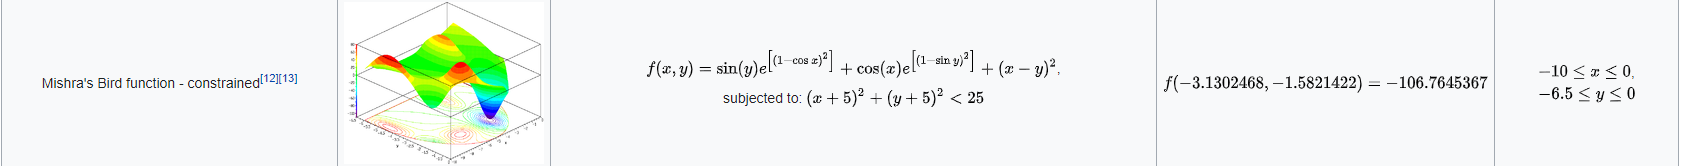

In [7]:
#Defines operators for the GA


def U(x, y):
    """Mishra's function to be optimised"""
    return math.sin(y) * math.e ** ((1 - math.cos(x))**2) + math.cos(x) * math.e **((1 - math.sin(y))**2) + (x - y) ** 2


def g(x, y):
    """Constraint penalty"""
    return (x + 5) ** 2 + (y + 5) ** 2 - 25


def Fitness(chromosome: list):
    """Fitness problem, minimization"""
    global count, bitConverter
    count+=1
    x = bitConverter.GetRealValue(chromosome, 1)
    y = bitConverter.GetRealValue(chromosome, 2)
    constraint = g(x, y)
    if (constraint > 0):
        penalty = constraint ** 3
    else:
        penalty = 0
    return -(U(x, y) + 10 * penalty)

time_start = time.time()

#instantiates real representation
numBits = 90
minimum = -10
maximum = 0
bitConverter = BitToReal([int(numBits/2), int(numBits/2)], minimum, maximum)
count = 0

#instantiates hyper parameter settings
settings = GASettings(numBits)
settings._mutation_rate = 1/(numBits/2)
settings._xoRate = 0.7
settings._generations = numBits

#runs the program & prints
GA = GASteadyStateBinary(Fitness, settings)
GA.Run()
winner = GA.GetBest()
winnerChrom = winner[0]
time_end = time.time()
bitStrings = bitConverter.GetBitArrays(winnerChrom)
x = bitConverter.GetRealValue(winnerChrom, 1)
y = bitConverter.GetRealValue(winnerChrom, 2)
print("Binary to real")
print("Bit N: " + str(numBits))
print("Range: '" + str(minimum) + "' to '" + str(maximum) + "'")
bitConverter.PrintResolutions()
print("----------------------------------")
print("Results of Mishra's Bird optimisation")
print("x bits: " + str(bitStrings[0]))
print("x value: " + str(x))
print("y bits: " + str(bitStrings[1]))
print("y value: " + str(y))
print("Total time in seconds: " + str(time_end - time_start))
print("Total evaluations: " + str(count))

Binary to real
Bit N: 90
Range: '-10' to '0'
Resolution Variable 0: 2.8421709430404815e-13
Resolution Variable 1: 2.8421709430404815e-13
----------------------------------
Results of Mishra's Bird optimisation
x bits: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1]
x value: -3.1249999999998046
y bits: [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1]
y value: -1.5821075451825557
Total time in seconds: 1.0534656047821045
Total evaluations: 16932


The representation is bit array of length 90 with bits 0-44 and 45-89 denoting parameters x and y respectively. We use a conversion from bits to a real number as given by class BitToReal's GetRealValue method, ultimately calling ConvertBinaryArrToReal on each variables bit array using formulas as detailed in lecture notes to attain real value.

The Fitness function is that of a minimisation problem for Mishra's birds formula, with the constraint denoted to this problem available on https://en.wikipedia.org/wiki/Test_functions_for_optimization

The Global minimums for this problem are x = -3.130 and y = -1.582. Given this our GA comes pretty close to an optimal solution with -3.12 and -1.58 with 16907 evaluations made.

## Travelling Salesman GA solution

In [45]:
# initialises representation
placesDict = {"A" : 0, "B" : 1, "C" : 2, "D": 3, "E": 4}
destinationsA = [("B", 100), ("C", 200), ("D", 150), ("E", 175)]
destinationsB = [("A", 100), ("E", 225), ("D", 250), ("C", 125)]
destinationsC = [("B", 125), ("A", 200), ("E", 275), ("D", 300)]
destinationsD = [("C", 300), ("B", 250), ("A", 150), ("E", 75)]
destinationsE = [("A", 175), ("B", 225), ("C", 275), ("D", 75)]
frontier = [destinationsA, destinationsB, destinationsC, destinationsD, destinationsE];
startingPoint = "A"
modulo = 0
count = 0
time_start = time.time()

#defines operators
def ConvertBinaryArrToInt(bitArr):
    """Converts a bit array into its integer representation
    Scaling is achieved given a modulo operator"""
    global modulo
    dec = sum(bitArr[i] * 2**i for i in range(len(bitArr)))
    dec = dec % modulo
    return dec

def Fitness(chromosome: list):
    global count, bitToInt, ConvertBinaryArrToInt, modulo
    count += 1
    arrays = bitToInt.GetBitArrays(chromosome)
    visited = []
    totalTrip = 0;
    destinations = frontier[0] # start at A, visit A's destinations
    for i in range(len(frontier)):
        modulo = len(destinations)
        
        #selection of place from destinations
        indexTo = ConvertBinaryArrToInt(arrays[i])
        destination = destinations[indexTo]
        
        #check destination letter not been travelled to already
        if(destination[0] in visited):
            return 0
        
        #add letter of new destination to list of visited and tot cost
        visited.append(destination[0])
        totalTrip += destination[1]
        
        # sets destinations to that of places travellable from selected destination
        destinations = frontier[placesDict[destination[0]]]
    if (visited[4] != startingPoint):
        return 0
    return 1/totalTrip

    #instantiates hyper parameters and  settings
    bitToInt = BitToReal([2, 2, 2, 2, 2], 0, 4)
    numBits = 2 * 5
    settings = GASettings(numBits)
    settings._mutation_rate = 0.01
    settings._xoRate = 0.7
    settings._generations = 50

    #runs the program
    GA = GASteadyStateBinary(Fitness, settings)
    GA.Run()
    winner = GA.GetBest()

    #calculates the trip cost and the trip made
    time_end = time.time()
    duration = time_end - time_start
    arrays = bitToInt.GetBitArrays(winner[0])
    visited = []
    totalTrip = 0;
    destinations = frontier[0] # start at A, visit A's destinations
    for i in range(len(frontier)):

        #selection of place from destinations
        indexTo = ConvertBinaryArrToInt(arrays[i])
        destination = destinations[indexTo]

        #add letter of new destination to set of visited
        visited.append(destination[0])
        totalTrip += destination[1]
        # sets destinations to that of places travellable from selected destination
        destinations = frontier[placesDict[destination[0]]]

    #prints stats
    print("GA Traveling salesman solution")
    print(f'Evaluations: {count}')
    print(f'Time taken: {duration}')
    print(f'Best Route: {visited}')
    print(f'Route Cost: {totalTrip}')

GA Traveling salesman solution
Evaluations: 16909
Time taken: 1.190244197845459
Best Route: ['B', 'C', 'E', 'D', 'A']
Route Cost: 725


The representation for the Travelling Salesman is a bit array chromosome with 2 bits per parameter for the genotype. For the phenotype, each gene represents an index into a destination array containing a letter to the next destination and its cost. The starting point is A, and destinationsA contains all the destinations attainable from A, destinationsB all the destinations from B and so fourth. The frontier contains all destinations indexed by the association in placesDict.

The Fitness algorithm converts all genes into their phenotype int indexes. For each index it calculates the next city 'letter' to travel to from the current destinations, checks the city has not been travelled to yet, and updates the destinations to reflect the next cities travellable to. Once a full trip has been made, the inverse cost is returned so that lower costs are valued greater than higer costs.

The algorithm occasionally finds the most optimal solution, in a higher time than the exhaustive search below.

## Travelling Salesman Exhaustive with pruning

In [144]:
count = 0
time_start = time.time()
class Node():
    global startingPoint
    def __init__(self,
                identifier = None,
                 cost = 0,
                parent = None):
        self._parent = parent
        self._id = identifier
        self._cost = cost
        self._visited = []
        self.PopulateVisited()
        self.MakeChildren(self)
    
    def PopulateVisited(self):
        parent = self;
        while(parent._id != None):
            self._visited.append(parent._id)
            parent = parent._parent
    
    def MakeChildren(self, that):
        global count, frontier, placesDict, visited
        count += 1
        if (that._id == None):
            front = frontier[0]
        else:
            front = frontier[placesDict[that._id]]
        children = []
        for i in range(len(front)):
            if (front[i][0] not in that._visited):
                children.append(Node(front[i][0], that._cost + front[i][1], that))
        that._children = children
        for child in that._children:
            child.MakeChildren(child)
    
    def GetRoutes(self):
        return self.GetRoute(self)
        
    def GetRoute(self, that):
        global startingPoint
        if (len(that._children) == 0):
            if (that._id == startingPoint):
                return [that]
            else:
                return []
        nodes = []
        for child in that._children:
            possibleRoutes = child.GetRoute(child)
            if (len(possibleRoutes) != 0):
                for i in range(len(possibleRoutes)):
                    nodes.append(possibleRoutes[i])
        return nodes

node = Node()
routes = node.GetRoutes()
time_end = time.time()
duration = time_end - time_start
highest = math.inf
routeTaken = []
for node in routes:
    if (node._cost < highest):
        highest = node._cost
        routeTaken = node._visited
routeTaken = [routeTaken[len(routeTaken) - 1 -i] for i in range(len(routeTaken))]
print("Exhaustive search of travelling salesman")
print(f'Number of solutions: {len(routes)}')
print(f'Evaluations: {count}')
print(f'Time taken: {duration}')
print(f'Best Route: {routeTaken}')
print(f'Route Cost: {highest}')

Exhaustive search of travelling salesman
Number of solutions: 24
Evaluations: 5065
Time taken: 0.021147727966308594
Best Route: ['B', 'C', 'E', 'D', 'A']
Route Cost: 725


The exhaustive solution is faster in terms of efficiency and optimal solution always found. However, this problems search space is 5! (factorial) = 120 states. Given 60 generations of 100 individuals it is expected that the GA would take longer than exhaustive search. More experiments are needed on problems with more complex search spaces to determine if the GA would outperform exhaustive.

## Conclusion

The genetic algorithm has shown to be quite versatile, with the only changes needed to be made for different problems being the respresentation of the problem (phenotype), and the fitness function to guide the natural selection. Solution times have been shown to run more optimally than exhaustive searches of the full search space domain (knapsack problem), whilst providing optimal solutions; although not always the perfect solution. The process is a stochastic method, which will not always reproduce the same results unless the random generator is seeded.